In [1]:
import datasets

import numpy as np
import torch
import torchaudio
import torchaudio.transforms as T
import pickle
import librosa
import torch
import torchgmm.bayes as bayes

from utils import group_samples_by_speaker, create_balanced_duration_dataset_from_groups,compute_mfcc, save_dataset_with_mfcc, load_dataset_with_mfcc




/Users/julienf/.pyenv/versions/3.11.11/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### download dataset

In [ ]:
"""
import aiohttp
dataset = datasets.load_dataset("librispeech_asr", 
                                "clean", 
                                split="train.100",
    storage_options={'client_kwargs': {'timeout': aiohttp.ClientTimeout(total=3600)}}
)
dataset.save_to_disk("./data/librispeech_hf")"""

### load and create subsets

In [2]:
dataset = datasets.load_from_disk("./data/librispeech_hf")

In [3]:
speaker_groups = group_samples_by_speaker(dataset)

In [9]:
# Create balanced datasets of different durations:

hdataset = create_balanced_duration_dataset_from_groups(speaker_groups, target_duration=10*3600)

Total accumulated duration: 35999.79 seconds


save subset

In [10]:
save_dataset_with_mfcc(hdataset, "./mfcc_datasets/h_mfcc")

Map:   0%|          | 0/2797 [00:00<?, ? examples/s]

Map: 100%|██████████| 2797/2797 [07:59<00:00,  5.84 examples/s]  


Dataset with MFCC features saved as ./mfcc_datasets/10h_mfcc


In [19]:
mfcc_dataset = load_dataset_with_mfcc("./mfcc_datasets/10h_mfcc")

In [20]:


# --- Step 1: Flatten MFCC frames from the dataset ---
# Each sample in mfcc_dataset has a key "mfcc" (a list of lists where each inner list is one MFCC frame)
all_mfcc_frames = []

for sample in mfcc_dataset:
    # Convert the mfcc list to a numpy array (shape: n_frames x n_mfcc)
    mfcc_frames = np.array(sample["mfcc"])
    all_mfcc_frames.append(mfcc_frames)

# Concatenate all frames along the time axis.
# This yields an array of shape (total_n_frames, n_mfcc)
all_mfcc = np.vstack(all_mfcc_frames)
print("Total MFCC frames:", all_mfcc.shape[0])
print("MFCC feature dimension:", all_mfcc.shape[1])

# Convert the NumPy array to a PyTorch tensor.
mfcc_tensor = torch.tensor(all_mfcc, dtype=torch.float32)


Total MFCC frames: 3602062
MFCC feature dimension: 13


In [21]:
torch.save(mfcc_tensor, './mfcc_tensors/10h_mfcc_tensor.pt')

### train 

In [35]:
mfcc_tensor = torch.load('./mfcc_tensors/10h_mfcc_tensor.pt')

In [36]:
print("Total MFCC frames:", mfcc_tensor.shape[0])

Total MFCC frames: 3602062


In [37]:
nb_clusters = 128  # set your desired number of Gaussian components

# Create the GMM model with batch training parameters.
gmm2 = bayes.GaussianMixture(
    num_components=nb_clusters,
    batch_size=1024,  # Process the data in batches of 1024 samples
    trainer_params={
        "max_epochs": 30,       # Number of epochs (passes through your data)
        "accelerator": "cpu",   # Force CPU training (MPS is not supported)
    }
)

In [38]:
gmm = gmm2.fit(mfcc_tensor)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=255` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 H

Epoch 24: 100%|██████████| 3518/3518 [00:07<00:00, 466.81it/s, nll=15.40]


In [39]:
save_path = "./trained_models/10h_trained_gmm"
gmm.save(save_path)
print(f"GMM model saved to {save_path}")

# 8. Later, you can load the model back using:
gmm = bayes.GaussianMixture.load(save_path)

GMM model saved to ./trained_models/10h_trained_gmm


In [40]:
# --- Using various methods ---

# 1. Predict the most likely component for each datapoint.
predicted_labels = gmm.predict(mfcc_tensor)
print("Predicted cluster assignments (first 10 datapoints):")
print(predicted_labels[:10])

# 2. Get the probability distribution (responsibilities) over components.
responsibilities = gmm.predict_proba(mfcc_tensor)
print("Responsibilities for the first 5 datapoints:")
print(responsibilities[:5])

# 3. Compute the average negative log-likelihood (NLL) for the data.
avg_nll = gmm.score(mfcc_tensor)
print(f"Average negative log-likelihood: {avg_nll:.2f}")



# 6. Inspect some of the fitted attributes:
#    (Note: The names of attributes may depend on your version of torchgmm.)
print("Convergence status:", gmm.converged_)
print("Number of EM iterations:", gmm.num_iter_)
print("Last recorded average NLL:", gmm.nll_)
"""
# 7. Optionally, save the model to disk.
save_path = "./trained_gmm"
gmm.save(save_path)
print(f"GMM model saved to {save_path}")"""

# 8. Later, you can load the model back using:
# loaded_gmm = bayes.GaussianMixture.load(save_path)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 3518/3518 [00:04<00:00, 810.72it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicted cluster assignments (first 10 datapoints):
tensor([109, 109, 109, 111,  55, 109, 111, 109,  30, 109])
Predicting DataLoader 0: 100%|██████████| 3518/3518 [00:03<00:00, 919.27it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Responsibilities for the first 5 datapoints:
tensor([[8.3531e-05, 7.4373e-25, 1.3796e-06, 6.4606e-13, 4.4417e-05, 4.2597e-20,
         1.5270e-08, 3.8381e-10, 2.9900e-13, 2.5768e-13, 7.2259e-03, 1.3631e-35,
         3.1787e-10, 2.5856e-27, 5.0516e-15, 5.8827e-09, 1.4956e-04, 1.5884e-05,
         3.2466e-29, 2.7198e-21, 9.1917e-13, 3.0638e-03, 3.5172e-17, 3.8881e-22,
         7.3561e-27, 1.4112e-04, 2.7238e-04, 1.8005e-08, 5.7461e-35, 1.8694e-06,
         7.8853e-02, 8.2977e-27, 2.8644e-09, 1.3699e-40, 8.4881e-06, 2.0093e-03,
         6.7132e-28, 1.4163e-04, 3.4128e-15, 1.3626e-28, 4.8137e-32, 2.0405e-28,
         1.9306e-05, 5.5196e-11, 6.6970e-08, 4.4558e-10, 1.0324e-20, 1.0887e-25,
         1.9489e-21, 1.1412e-06, 3.2950e-26, 2.8202e-07, 1.6455e-18, 8.8724e-08,
         3.4037e-20, 7.1883e-02, 3.1835e-20, 1.4323e-27, 8.5881e-13, 3.2833e-23,
         1.8748e-36, 2.9798e-09, 8.8003e-14, 8.8659e-11, 1.3561e-10, 2.4299e-09,
         7.1185e-25, 8.7284e-14, 1.5983e-07, 3.6775e-14, 2.3721e

'\n# 7. Optionally, save the model to disk.\nsave_path = "./trained_gmm"\ngmm.save(save_path)\nprint(f"GMM model saved to {save_path}")'

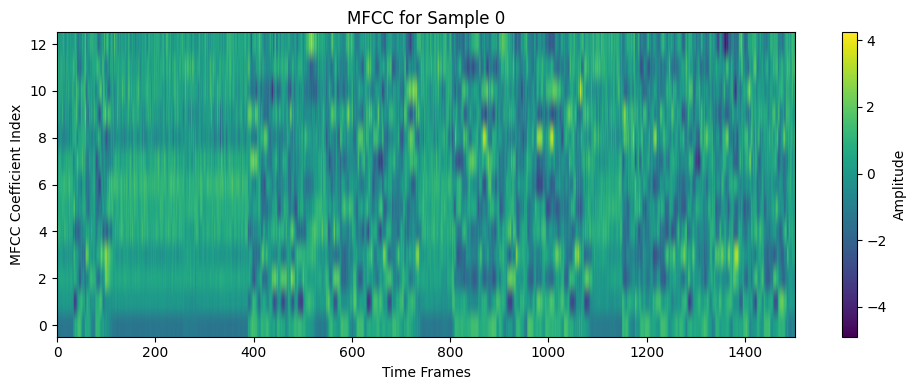

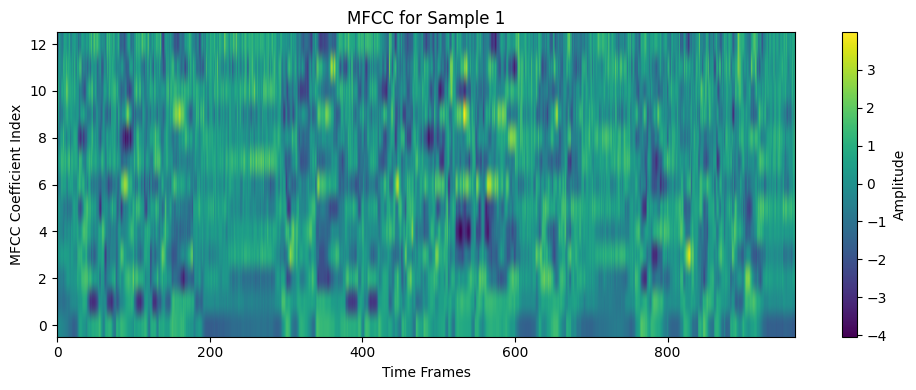

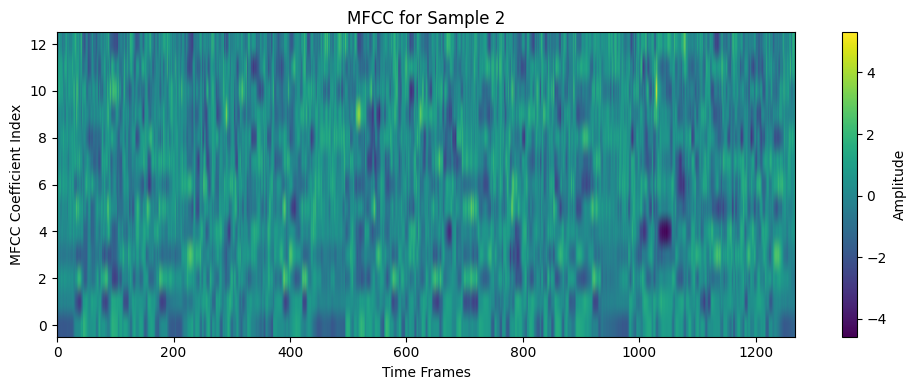

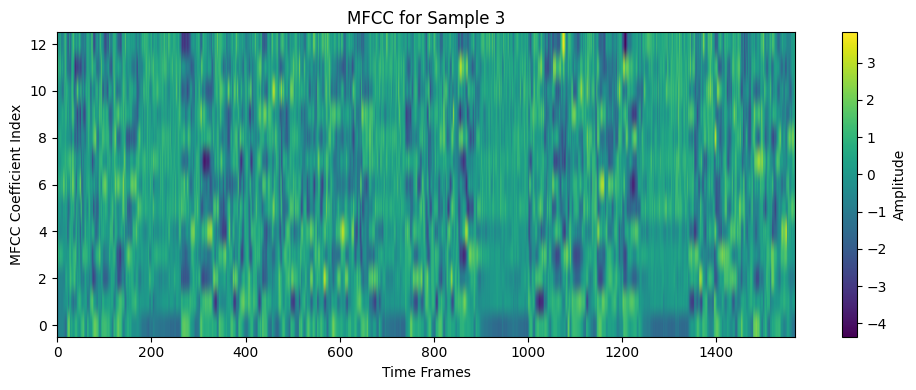

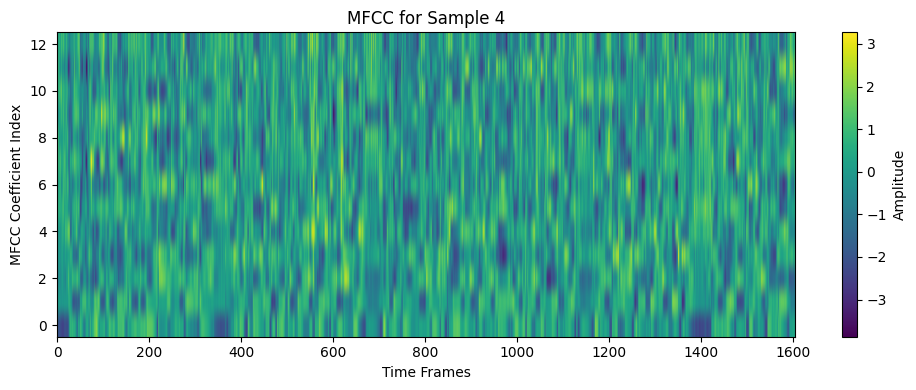

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Number of samples you want to visualize
num_samples_to_visualize = 5

for i in range(num_samples_to_visualize):
    sample = data1h_with_mfcc[i]
    # Convert MFCC from list-of-lists to a NumPy array
    mfcc = np.array(sample["mfcc"])  # shape: (n_frames, n_mfcc)
    
    plt.figure(figsize=(10, 4))
    # Transpose the array so that time is on the x-axis and MFCC indices are on the y-axis.
    plt.imshow(mfcc.T, origin='lower', aspect='auto', cmap='viridis')
    plt.title(f"MFCC for Sample {i}")
    plt.xlabel("Time Frames")
    plt.ylabel("MFCC Coefficient Index")
    plt.colorbar(label="Amplitude")
    plt.tight_layout()
    plt.show()

Visualizing 3 samples from cluster 3


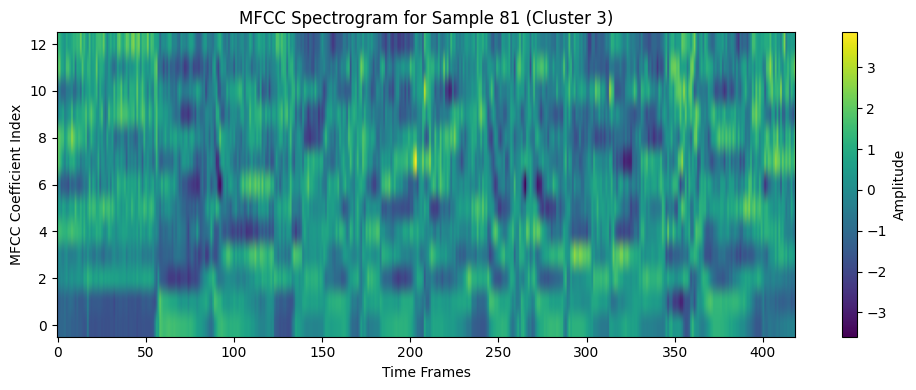

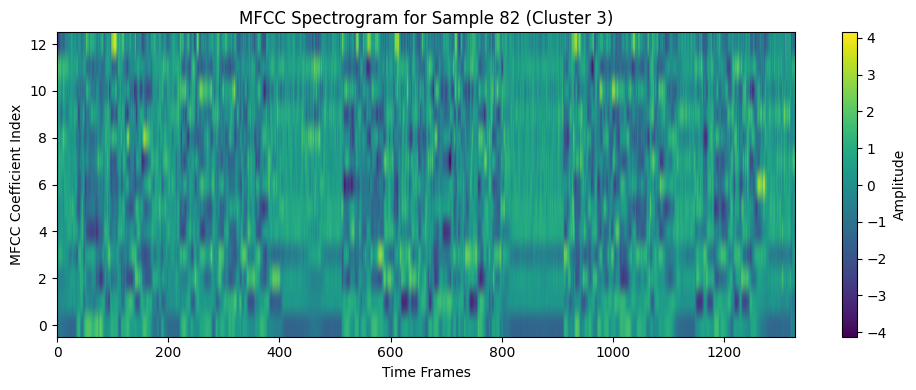

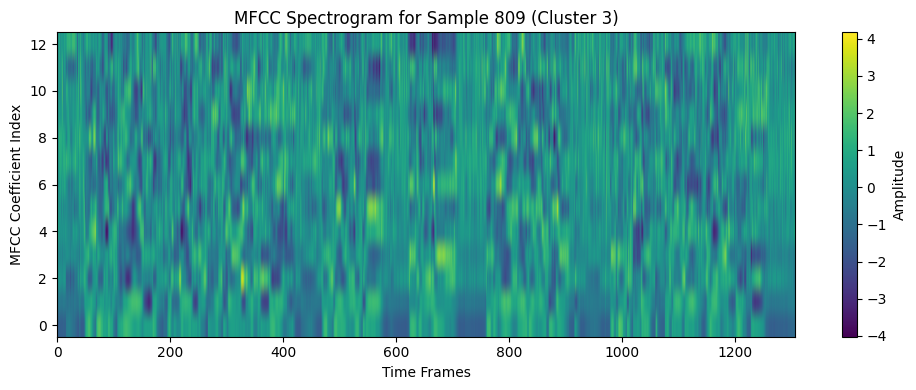

Visualizing 3 samples from cluster 30


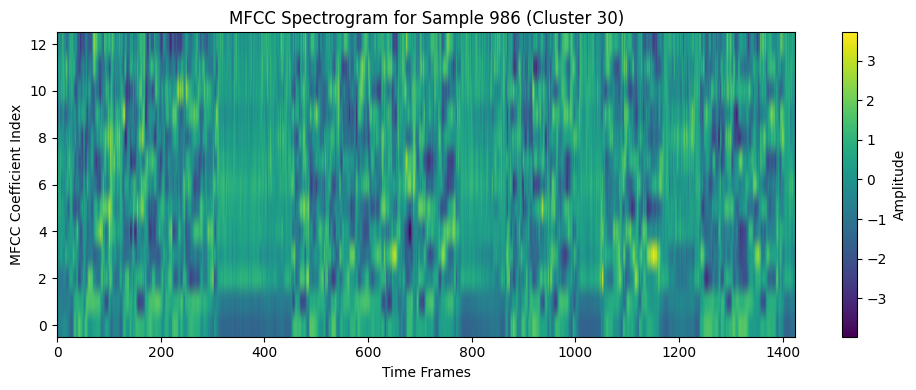

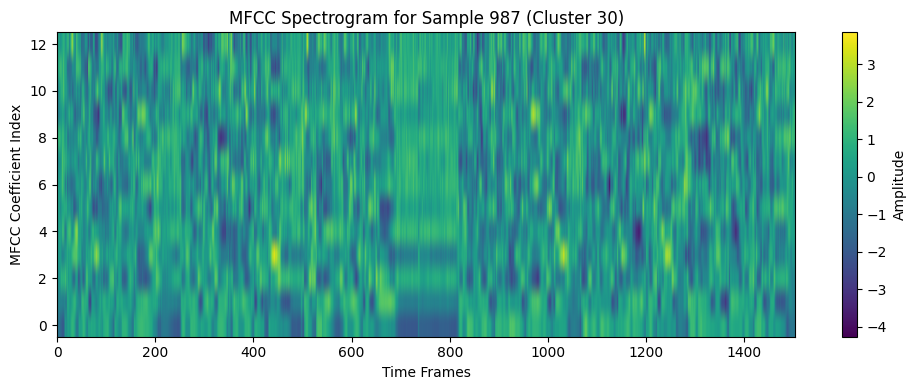

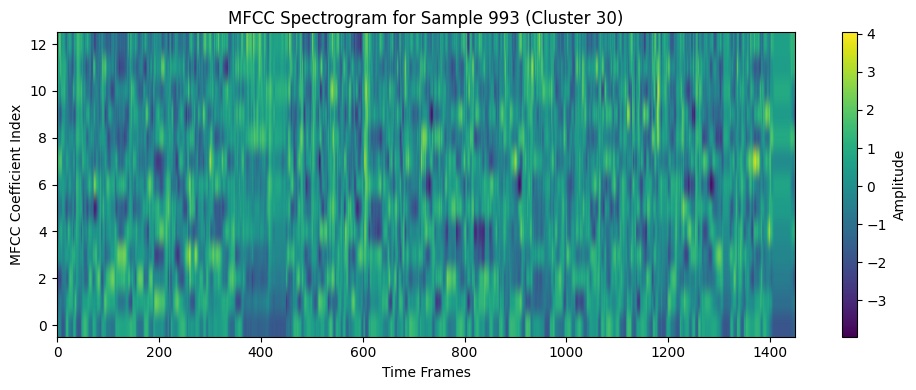

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose mfcc_dataset is your list of samples with the "mfcc" field.
# And predicted_labels is obtained by:
# predicted_labels = gmm.predict(mfcc_tensor)
#
# Here we assume that mfcc_dataset and predicted_labels are aligned.
# (Make sure that the order of MFCC frames in mfcc_tensor corresponds to the order of your samples.)
#
# For demonstration, let's assume we want to visualize samples assigned to cluster 3 and cluster 30.

# First, group the indices by predicted cluster.
cluster_to_indices = {}
for idx, cluster in enumerate(predicted_labels.tolist()):
    cluster_to_indices.setdefault(cluster, []).append(idx)

# Define which clusters you want to visualize:
clusters_to_visualize = [3, 30]
num_samples_per_cluster = 3  # number of samples to visualize for each cluster

for cluster in clusters_to_visualize:
    indices = cluster_to_indices.get(cluster, [])
    if not indices:
        print(f"No samples assigned to cluster {cluster}.")
        continue
    
    print(f"Visualizing {min(num_samples_per_cluster, len(indices))} samples from cluster {cluster}")
    
    # Visualize up to num_samples_per_cluster samples from this cluster
    for i in indices[:num_samples_per_cluster]:
        sample = data1h_with_mfcc[i]
        mfcc = np.array(sample["mfcc"])  # shape: (n_frames, n_mfcc)
        
        plt.figure(figsize=(10, 4))
        plt.imshow(mfcc.T, origin='lower', aspect='auto', cmap='viridis')
        plt.title(f"MFCC Spectrogram for Sample {i} (Cluster {cluster})")
        plt.xlabel("Time Frames")
        plt.ylabel("MFCC Coefficient Index")
        plt.colorbar(label="Amplitude")
        plt.tight_layout()
        plt.show()

In [ ]:

import os

def process_stimulus(audio_file_path, sample_rate=16000):
    # Load the audio using librosa (or another method)
    audio_array, sr = librosa.load(audio_file_path, sr=sample_rate)
    mfcc_features = compute_mfcc(audio_array, sr)
    return mfcc_features  # NumPy array of shape (n_frames, n_mfcc)

# List your stimulus file paths (16 audio files)
stimulus_files = os.listdir("./sounds")
stimulus_files = [os.path.join("./sounds", file) for file in stimulus_files]

print(stimulus_files)  


# Process each stimulus
stimulus_mfccs = []
for file_path in stimulus_files:
    print(f"Processing stimulus: {file_path}")
    mfcc = process_stimulus(file_path)
    stimulus_mfccs.append(mfcc)

# --- Step 2: Get cluster responsibilities for each stimulus ---
# Suppose gmm is your trained GaussianMixture model.
# We will compute the average responsibilities per stimulus.

stimulus_cluster_posteriors = []  # list of shape (num_components,) per stimulus
stimulus_labels = ["l",
                   "l",
                   "l",
                   "l",
                   "r",
                   "r",
                   "r",
                   "l",
                   "r",
                   "r",
                   "r",
                   "l",
                   "r",
                   "l",
                   "l",
                    "r"]


for mfcc in stimulus_mfccs:
    # Convert to torch tensor (float32)
    mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32)
    # Get responsibilities (posterior probabilities) for each frame.
    responsibilities = gmm.predict_proba(mfcc_tensor)
    # Average the responsibilities over all frames.
    print("resp",responsibilities.shape)
    avg_resp = responsibilities.mean(dim=0)
    print("avg",avg_resp.shape)
    stimulus_cluster_posteriors.append(avg_resp.detach().cpu().numpy())

# Now, stimulus_cluster_posteriors is a list of 16 vectors (each of length num_components).



GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/julienf/.pyenv/versions/3.11.11/envs/ml/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


['./sounds/11_yt12024.wav', './sounds/16_yt14028.wav', './sounds/3_yt8024.wav', './sounds/8_yt10028.wav', './sounds/14_yt14020.wav', './sounds/6_yt10020.wav', './sounds/13_yt14016.wav', './sounds/12_yt12028.wav', './sounds/10_yt12020.wav', './sounds/2_yt8020.wav', './sounds/9_yt12016.wav', './sounds/4_yt8028.wav', './sounds/5_yt10016.wav', './sounds/15_yt14024.wav', './sounds/7_yt10024.wav', './sounds/1_yt8016.wav']
Processing stimulus: ./sounds/11_yt12024.wav
Processing stimulus: ./sounds/16_yt14028.wav
Processing stimulus: ./sounds/3_yt8024.wav
Processing stimulus: ./sounds/8_yt10028.wav
Processing stimulus: ./sounds/14_yt14020.wav
Processing stimulus: ./sounds/6_yt10020.wav
Processing stimulus: ./sounds/13_yt14016.wav
Processing stimulus: ./sounds/12_yt12028.wav
Processing stimulus: ./sounds/10_yt12020.wav
Processing stimulus: ./sounds/2_yt8020.wav
Processing stimulus: ./sounds/9_yt12016.wav
Processing stimulus: ./sounds/4_yt8028.wav
Processing stimulus: ./sounds/5_yt10016.wav
Proce

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



resp torch.Size([59, 128])
avg torch.Size([128])
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.18it/s] 

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



resp torch.Size([59, 128])
avg torch.Size([128])
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.79it/s] 
resp torch.Size([59, 128])
avg torch.Size([128])


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.47it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



resp torch.Size([59, 128])
avg torch.Size([128])
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.25it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



resp torch.Size([59, 128])
avg torch.Size([128])
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.30it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



resp torch.Size([59, 128])
avg torch.Size([128])
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 169.52it/s]
resp torch.Size([59, 128])
avg torch.Size([128])


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 427.21it/s]
resp torch.Size([59, 128])
avg torch.Size([128])


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 382.55it/s]
resp torch.Size([59, 128])
avg torch.Size([128])


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 368.50it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



resp torch.Size([59, 128])
avg torch.Size([128])
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 482.66it/s]
resp torch.Size([59, 128])
avg torch.Size([128])


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 577.33it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



resp torch.Size([59, 128])
avg torch.Size([128])
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 374.36it/s]
resp torch.Size([59, 128])
avg torch.Size([128])


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 578.37it/s]
resp torch.Size([59, 128])
avg torch.Size([128])


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 531.93it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



resp torch.Size([59, 128])
avg torch.Size([128])
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 375.63it/s]
resp torch.Size([59, 128])
avg torch.Size([128])


In [53]:
stimulus_cluster_posteriors[0].shape

(128,)

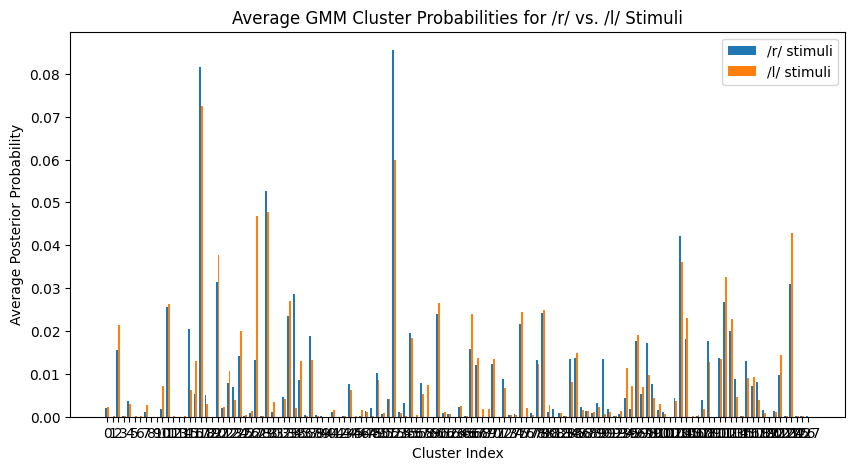

In [57]:
# Example inputs:
# stimulus_cluster_posteriors: list of 16 numpy arrays, each of shape (num_clusters,)
# For instance, if you have 32 clusters then each array is of shape (32,).
# These come from averaging the responsibilities (posterior probabilities) over the MFCC frames of each stimulus.


# stimulus_labels: a list of 16 labels corresponding to your 16 stimuli.
# Here we assume that the stimuli are labeled "r" for /r/ sounds and "l" for /l/ sounds.


# Convert the list of posterior vectors into a 2D array for easier manipulation.
posteriors = np.stack(stimulus_cluster_posteriors, axis=0)  # shape: (num_stimuli, num_clusters)
num_stimuli, num_clusters = posteriors.shape

# Separate indices for /r/ and /l/ stimuli.
r_indices = [i for i, lab in enumerate(stimulus_labels) if lab.lower() == "r"]
l_indices = [i for i, lab in enumerate(stimulus_labels) if lab.lower() == "l"]

# Compute average posterior probability for each cluster for each group.
avg_r = posteriors[r_indices, :].mean(axis=0)
avg_l = posteriors[l_indices, :].mean(axis=0)

# Plot the average probabilities for each cluster side by side.
x = np.arange(num_clusters)
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - width/2, avg_r, width, label="/r/ stimuli")
ax.bar(x + width/2, avg_l, width, label="/l/ stimuli")
ax.set_xlabel("Cluster Index")
ax.set_ylabel("Average Posterior Probability")
ax.set_title("Average GMM Cluster Probabilities for /r/ vs. /l/ Stimuli")
ax.set_xticks(x)
ax.legend()
plt.show()


In [21]:
responsibilities = gmm.predict_proba(mfcc_tensor)  # shape: [N, K]
effective_counts = responsibilities.sum(axis=0)
print("Effective counts per cluster:", effective_counts)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 417.22it/s]
Effective counts per cluster: tensor([2.4820e+00, 5.7847e-02, 3.0198e-02, 2.1786e-02, 9.0633e-01, 7.6081e-03,
        1.5755e+00, 9.2200e-01, 6.3391e-03, 3.8738e-01, 3.9720e-04, 3.5198e-03,
        5.9611e+00, 2.5203e+00, 1.2699e-03, 5.5105e-03, 1.2530e+00, 7.7476e-14,
        7.2537e-01, 6.9659e-06, 5.5960e-02, 2.7549e-03, 4.6877e-03, 1.5519e-01,
        3.0265e-06, 1.0693e-02, 3.5591e+00, 3.1595e-03, 1.4851e-01, 1.5001e-02,
        5.1457e-06, 4.3690e-03, 1.0318e-01, 6.3093e-04, 3.5968e-03, 6.8954e-02,
        7.1606e-04, 6.9499e-01, 2.8716e-06, 1.7519e-06, 8.6899e-02, 1.8039e-01,
        3.4019e-03, 4.4030e-04, 1.5520e-01, 2.4830e-03, 1.1313e+00, 6.2859e-07,
        1.7756e-01, 4.9084e-01, 1.7178e+00, 5.7579e-05, 4.6857e-06, 2.2893e-01,
        1.1950e-05, 3.1054e-01, 6.7994e-02, 7.5120e-03, 7.9529e-01, 1.4434e+00,
        2.2861e+00, 2.4223e-01, 6.4329e-02, 3.0603e-02, 2.0143e-01, 5.6185e-01,
        3.0889e-04

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/Users/julienf/.pyenv/versions/3.11.11/envs/ml/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 381.96it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 422.26it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 510.19it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 585.88it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 467.23it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 611.68it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 496.78it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 557.75it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.06it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 417.22it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 577.33it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 395.28it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 542.04it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 476.41it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 697.42it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 535.40it/s]


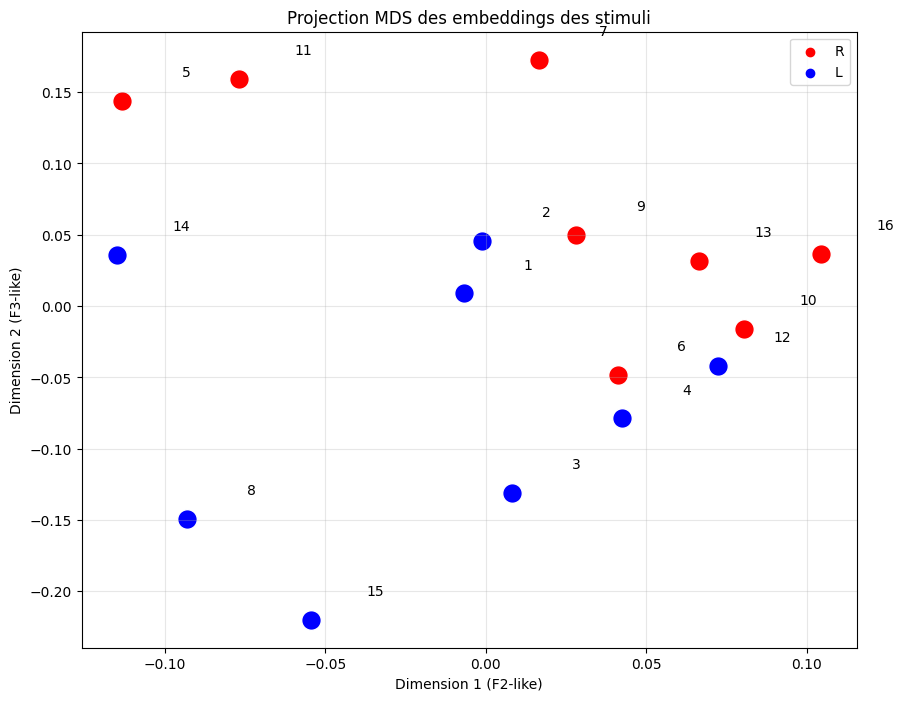

In [61]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform

# --- 1. Charger le modèle entraîné ---
model_path = "./trained_models/10h_trained_gmm"  # <-- À modifier
gmm = bayes.GaussianMixture.load(model_path)


# --- 2. Calcul des embeddings des stimuli ---
stimulus_embeddings = []
for mfcc in stimulus_mfccs:  # Utilisez vos MFCC pré-calculés
    with torch.no_grad():
        mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32)
        responsibilities = gmm.predict_proba(mfcc_tensor)
        avg_embedding = responsibilities.mean(dim=0).numpy()
        stimulus_embeddings.append(avg_embedding)

# --- 3. Calcul de la matrice de distance ---
distance_matrix = squareform(pdist(stimulus_embeddings, metric='cosine'))

# --- 4. Réduction de dimension avec MDS ---
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_coords = mds.fit_transform(distance_matrix)

# --- 5. Visualisation ---
plt.figure(figsize=(10, 8))
colors = ['red' if label == 'r' else 'blue' for label in stimulus_labels]

# Plot chaque stimulus avec son numéro
for i, (x, y) in enumerate(mds_coords):
    plt.scatter(x, y, c=colors[i], s=200, edgecolor='w', linewidth=1)
    plt.text(x+0.02, y+0.02, str(i+1), fontsize=10, ha='center', va='center')

# Légende
plt.scatter([], [], c='red', label='R')
plt.scatter([], [], c='blue', label='L')
plt.legend(loc='best')

plt.title("Projection MDS des embeddings des stimuli")
plt.xlabel("Dimension 1 (F2-like)")
plt.ylabel("Dimension 2 (F3-like)")
plt.grid(alpha=0.3)
plt.show()

# --- 6. Sauvegarde des résultats ---
np.save("mds_coords.npy", mds_coords)
np.save("distance_matrix.npy", distance_matrix)

In [ ]:
import numpy as np
from sklearn.manifold import MDS
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration globale
N_COMPONENTS = 128  
N_MDS_DIMENSIONS = 2
TRAINING_DURATIONS = ['1h', '10h', '100h']
N_SEEDS = 1

# Fonction pour charger les modèles entraînés
def load_models(duration, n_seeds):
    models = []
    for seed in range(n_seeds):
        model_path = f"./models/gmm_{duration}_seed{seed}.pt"
        models.append(torch.load(model_path))
    return models

# Calcul des embeddings moyens sur plusieurs runs
def compute_average_embeddings(models, stimulus_mfccs):
    all_embeddings = []
    for model in models:
        embeddings = []
        for mfcc in stimulus_mfccs:
            mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32)
            responsibilities = model.predict_proba(mfcc_tensor)
            avg_resp = responsibilities.mean(dim=0).detach().cpu().numpy()
            embeddings.append(avg_resp)
        all_embeddings.append(np.array(embeddings))
    return np.mean(all_embeddings, axis=0)

# Analyse MDS pour une durée d'entraînement
def analyze_duration(duration, stimulus_mfccs, stimulus_labels):
    # Charger les modèles
    models = load_models(duration, N_SEEDS)
    
    # Calculer les embeddings moyens
    avg_embeddings = compute_average_embeddings(models, stimulus_mfccs)
    
    # Calcul de la matrice de distance moyenne
    distance_matrix = cdist(avg_embeddings, avg_embeddings, metric='cosine')
    
    # Réduction de dimension avec MDS
    mds = MDS(n_components=N_MDS_DIMENSIONS, dissimilarity='precomputed', random_state=42)
    mds_coords = mds.fit_transform(distance_matrix)
    
    # Visualisation
    plt.figure(figsize=(10, 8))
    colors = ['red' if label == 'R' else 'blue' for label in stimulus_labels]
    
    for i, (x, y) in enumerate(mds_coords):
        plt.scatter(x, y, c=colors[i], s=100)
        plt.text(x+0.02, y+0.02, str(i+1), fontsize=9)
    
    plt.title(f"MDS - {duration} d'entraînement")
    plt.xlabel("Dimension 1 (F2-like)")
    plt.ylabel("Dimension 2 (F3-like)")
    
    # Sauvegarde des coordonnées
    np.save(f"mds_{duration}.npy", mds_coords)
    plt.savefig(f"mds_{duration}.png")
    plt.close()

# Analyse comparative sur toutes les durées
def full_analysis(stimulus_mfccs, stimulus_labels):
    fig, axes = plt.subplots(1, len(TRAINING_DURATIONS), figsize=(20, 6))
    
    for idx, duration in enumerate(TRAINING_DURATIONS):
        models = load_models(duration, N_SEEDS)
        avg_embeddings = compute_average_embeddings(models, stimulus_mfccs)
        distance_matrix = cdist(avg_embeddings, avg_embeddings, metric='cosine')
        mds = MDS(n_components=N_MDS_DIMENSIONS, dissimilarity='precomputed', random_state=42)
        mds_coords = mds.fit_transform(distance_matrix)
        
        colors = ['red' if label == 'R' else 'blue' for label in stimulus_labels]
        axes[idx].scatter(mds_coords[:,0], mds_coords[:,1], c=colors, s=100)
        axes[idx].set_title(duration)
        axes[idx].set_xlabel("Dimension 1")
        axes[idx].set_ylabel("Dimension 2")
    
    plt.tight_layout()
    plt.savefig("mds_comparison.png")
    plt.close()

# Exécution principale
if __name__ == "__main__":
    # Charger les MFCC des stimuli (déjà calculés)
    stimulus_mfccs = [...]  # Remplacer par vos données
    
    # Vérifier les labels
    stimulus_labels = [...]  # Liste de 16 labels R/L
    
    # Analyse par durée
    for duration in TRAINING_DURATIONS:
        analyze_duration(duration, stimulus_mfccs, stimulus_labels)
    
    # Analyse comparative
    full_analysis(stimulus_mfccs, stimulus_labels)

    # Analyse statistique des dimensions
    for duration in TRAINING_DURATIONS:
        coords = np.load(f"mds_{duration}.npy")
        print(f"\nAnalyse pour {duration}:")
        print(f"Variance expliquée - Dim1: {np.var(coords[:,0]):.2f}, Dim2: {np.var(coords[:,1]):.2f}")
        print(f"Ratio F2/F3: {np.var(coords[:,0])/np.var(coords[:,1]):.2f}")